# BIG DATA TOOLS FOR BUSINESS PROJECT - PART 2 - REAL ESTATE


##    PART 0 - LIBRARIES IMPORTANTIONS, LOAD DATASET AND TRANSFORM TO SPRAK DATAFRAME


In [6]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import col

%matplotlib inline
import matplotlib.pyplot as plt

spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-SQL-Solutions").getOrCreate()

In [7]:
real_estate_df = spark.read.csv('real_estate_transactions.csv', header=True, sep=';')

In [8]:
real_estate_df.show(10)

+----+----------+---------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+
|City| Sale Date|Sale Type|    Price|Postal Code|Commune|Number of lots|Local Type|Living Area|Number of rooms|Land Area|
+----+----------+---------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+
|NICE|26/03/2015|     SALE|102000,00|       6000|   NICE|             1| APARTMENT|         29|              2|     null|
|NICE|07/04/2015|     SALE| 32000,00|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|10/04/2015|     SALE|239000,00|       6200|   NICE|             1| APARTMENT|         51|              2|     null|
|NICE|10/04/2015|     SALE|239000,00|       6200|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|23/03/2015|     SALE| 30000,00|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|23/03/2015|     SA


##    PART 1 - CLEAN AND OUTLIERS


###      1.0 - Variables datatype recoding & date format conversion

In [4]:
real_estate_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Sale Date: string (nullable = true)
 |-- Sale Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Commune: string (nullable = true)
 |-- Number of lots: string (nullable = true)
 |-- Local Type: string (nullable = true)
 |-- Living Area: string (nullable = true)
 |-- Number of rooms: string (nullable = true)
 |-- Land Area: string (nullable = true)



In [5]:
from pyspark.sql.types import *

real_estate_schema =StructType ( [StructField("City", StringType(), True),
                                  StructField("Sale_Date", DateType(), True),
                                  StructField("Sale_Type", StringType(), True),
                                  StructField("Price", DecimalType(), True),
                                  StructField("Postal_Code", IntegerType(), True),
                                  StructField("Commune", StringType(), True),
                                  StructField("Number_of_lots", IntegerType(), True),
                                  StructField("Local_Type", StringType(), True),
                                  StructField("Living_Area", IntegerType(), True),
                                  StructField("Number_of_rooms", IntegerType(), True),
                                  StructField("Land_Area", IntegerType(), True)])

In [9]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

real_estate_df = spark.read.csv('real_estate_transactions.csv', header=True, sep=';', dateFormat='dd/MM/YYYY', schema=real_estate_schema)

In [10]:
real_estate_df.createOrReplaceTempView('real_estate')


###     1.1 - Price Variable Recoding


In [11]:
real_estate_df = real_estate_df.withColumn("Price",col('Price')/100)
real_estate_df = real_estate_df.withColumn("Price",F.round(real_estate_df["Price"],0).cast('integer'))


###     1.2 - SaleType filter operation


In [12]:
#1st outlier Op = Sale Type
real_estate_df_count_sale_type = real_estate_df.select("*").groupBy('Sale_Type').agg({'Sale_Type':'count'})
#real_estate_df_count_sale_type.show()
real_estate_df = real_estate_df.filter('Sale_Type=="SALE" or Sale_Type=="SALE BEFORE COMPLETION"')
#real_estate_df.show()
real_estate_df = real_estate_df.replace('SALE BEFORE COMPLETION', ['SALE PENDING'],'Sale_Type')
#real_estate_df.show()


###     1.3 - NA Cleaning (DROP and FILL Operation)


In [13]:
real_estate_df = real_estate_df.dropna(how='any',subset=['Postal_Code','Price'])
#real_estate_df.show()

In [14]:
real_estate_df = real_estate_df.fillna(0,subset=['Land_Area'])
#real_estate_df.show()

###     1.4 - "YEARS" and "MONTHS" variables creation

In [15]:
real_estate_df = real_estate_df.withColumn('Years',F.year(F.to_timestamp('Sale_Date', 'yyyy-mm-dd')))
#real_estate_df.show()
real_estate_df = real_estate_df.withColumn('Months',F.month(F.to_timestamp('Sale_Date', 'yyyy-mm-dd')))
#real_estate_df.show()

###     1.5 - B2C and B2B Activities split

In [16]:
#SEPARATION BETWEEN B2C DATASET (HOUSE & APARTEMENT) AND B2B DATASET (INDUSTRIAL LOCATION)
#PART A = B2C
real_estate_df_count_local_type = real_estate_df.select("*").groupBy('Local_Type').agg({'Local_Type':'count'})
real_estate_df_count_local_type.show()

+--------------------+-----------------+
|          Local_Type|count(Local_Type)|
+--------------------+-----------------+
|               HOUSE|            37537|
|                null|                0|
|          DEPENDENCY|           238265|
|           APARTMENT|           439801|
|INDUSTRIAL/COMMER...|            57578|
+--------------------+-----------------+



In [17]:
B2C_df = real_estate_df.filter('Local_Type=="HOUSE" or Local_Type=="APARTMENT"')
#B2C_df.show()
B2B_df = real_estate_df.filter('Local_Type=="INDUSTRIAL/COMMERCIAL LOCATION"')
#B2B_df.show()
Global_df = real_estate_df.filter('Local_Type=="HOUSE" or Local_Type=="APARTMENT" or Local_Type=="INDUSTRIAL/COMMERCIAL LOCATION"')

###     1.6 - Cleaning the "Out-of-law" items from the dataset (On B2C market)

In [18]:
B2C_df = B2C_df.filter('Living_Area>9')
#B2C_df.show()

###     1.7 - Extrem values cleaning (On B2C market)

In [19]:
#Outliers 1 : Price Range
B2C_df_p = B2C_df.agg(
                                    F.expr('percentile(Price, array(0.01))')[0].alias('%1'),
                                    F.expr('percentile(Price, array(0.01))')[0].alias('%5'),
                                    F.expr('percentile(Price, array(0.10))')[0].alias('%10'),
                                    F.expr('percentile(Price, array(0.20))')[0].alias('%20'),
                                    F.expr('percentile(Price, array(0.30))')[0].alias('%30'),
                                    F.expr('percentile(Price, array(0.40))')[0].alias('%40'),
                                    F.expr('percentile(Price, array(0.50))')[0].alias('%50'),
                                    F.expr('percentile(Price, array(0.60))')[0].alias('%60'),
                                    F.expr('percentile(Price, array(0.70))')[0].alias('%70'),
                                    F.expr('percentile(Price, array(0.80))')[0].alias('%80'),
                                    F.expr('percentile(Price, array(0.90))')[0].alias('%90'),
                                    F.expr('percentile(Price, array(0.95))')[0].alias('%95'),
)

B2C_df_p.show()

+-------+-------+-------+--------+--------+--------+--------+--------+--------+-----------------+---------+---------+
|     %1|     %5|    %10|     %20|     %30|     %40|     %50|     %60|     %70|              %80|      %90|      %95|
+-------+-------+-------+--------+--------+--------+--------+--------+--------+-----------------+---------+---------+
|16500.0|16500.0|90000.0|125000.0|157250.0|194000.0|238040.0|300000.0|392000.0|555604.0000000002|1045803.0|2499879.0|
+-------+-------+-------+--------+--------+--------+--------+--------+--------+-----------------+---------+---------+



In [20]:
B2C_df = B2C_df.filter('Price<1045803.0')
B2C_df = B2C_df.filter('Price>90000.0')


##    PART 2 - MARKET ANALYSIS - STUDY OF THE PRICE PER SQUARE METERS


In [21]:
real_estate_df = B2C_df

### Price Sqm Spreading Study (Bar Chart)

array([[<AxesSubplot:title={'center':'Price_Sqmeters'}>]], dtype=object)

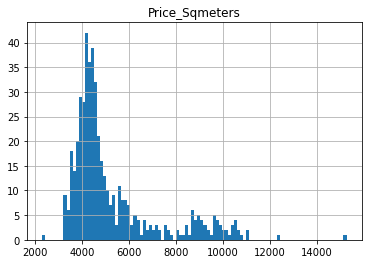

In [22]:
#SQM_SPREADING
real_estate_df = real_estate_df.withColumn("Price_Sqm",col('Price')/col('Living_Area'))
#real_estate_df.show(5)

real_estate_df = real_estate_df.withColumn("Price_Sqm", F.round(real_estate_df["Price_Sqm"],0).cast('integer'))
#real_estate_df.show()

real_estate_df_sqm_spreading = real_estate_df.select("*").groupBy('City','Years','Months').agg({'Price_Sqm':'average'}).sort('City','Years','Months', ascending=True)
#real_estate_df_sqm_spreading.show()

real_estate_df_sqm_spreading = real_estate_df_sqm_spreading.withColumn("Price_Sqmeters", F.round(real_estate_df_sqm_spreading["avg(Price_Sqm)"],0).cast('integer'))
#real_estate_df_sqm_spreading.show()

df_pd = real_estate_df_sqm_spreading.toPandas()

#plt.title('Price per square meters over the years',fontweight ="bold") 
df_pd.hist(column='Price_Sqmeters',bins=100)

### Study of the evolution of the real estate market (Simple Line Chart)

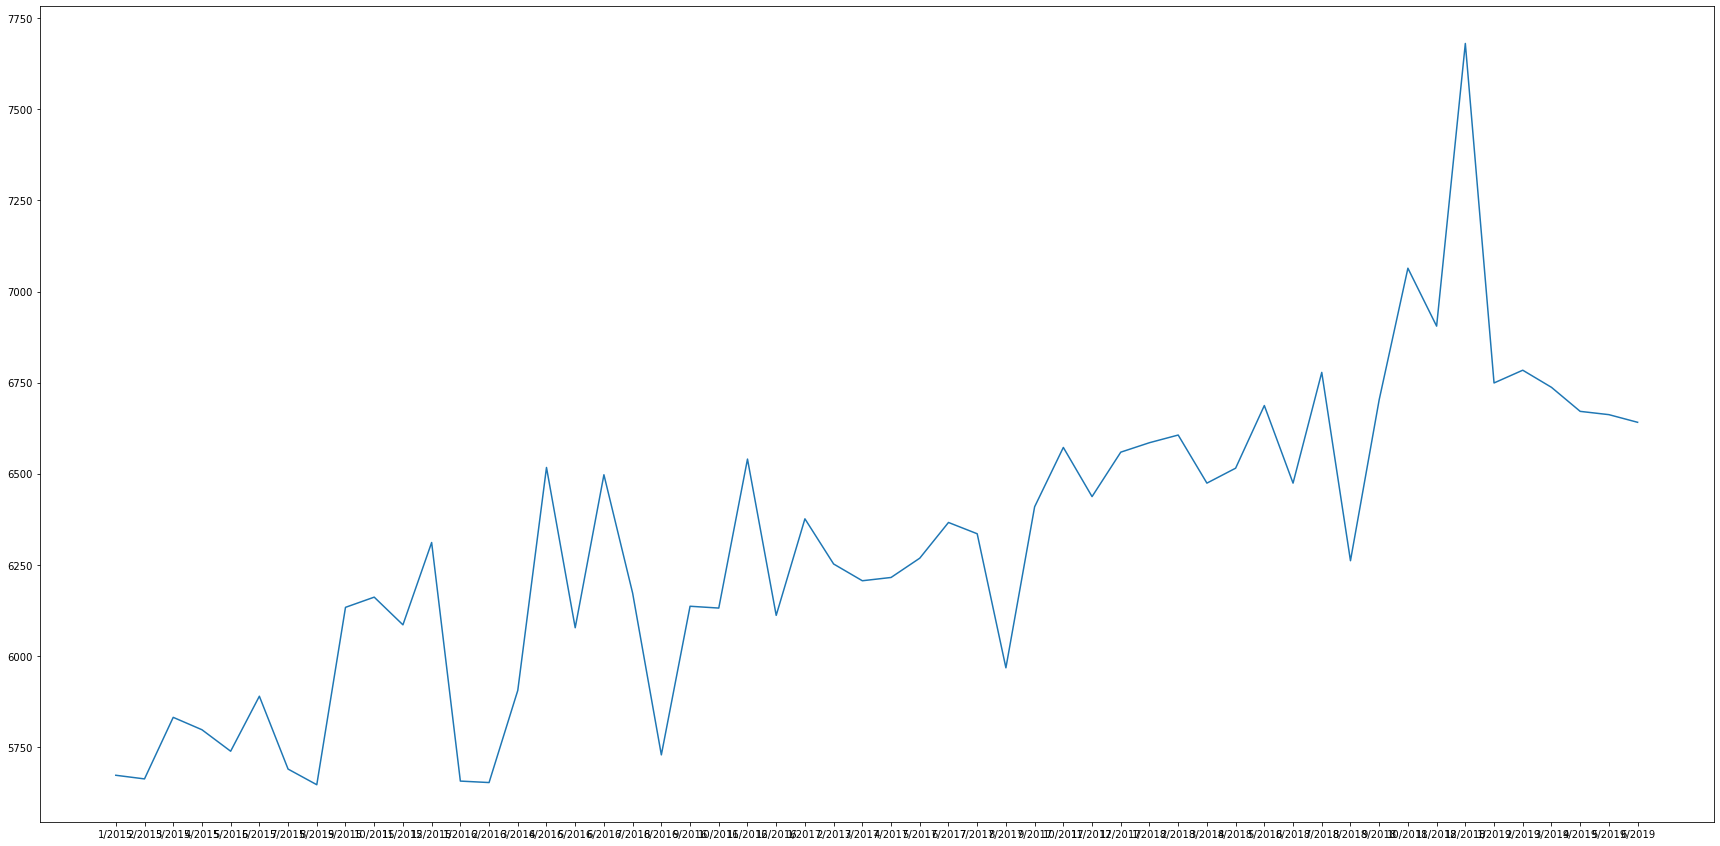

In [23]:
#STEP1
real_estate_df_sqm_years = real_estate_df.select("*").groupBy('Years','Months').agg({'Price_Sqm':'average'}).sort('Years','Months', ascending=True)
#real_estate_df_sqm_years.show()

#STEP2
real_estate_df_sqm_years = real_estate_df_sqm_years.withColumn("Price_Sqmeters", F.round(real_estate_df_sqm_years["avg(Price_Sqm)"],0).cast('integer'))
#real_estate_df_sqm_years.show()

#STEP4
real_estate_df_sqm_years = real_estate_df_sqm_years.withColumn('Month_of_Year', 
                    F.concat(F.col('Months'),F.lit('/'), F.col('Years')))
#real_estate_df_sqm_years.show()

#STEP4
PSq_list = list(
    real_estate_df_sqm_years.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(PSq_list)

Date_list = list(
    real_estate_df_sqm_years.select('Month_of_Year').toPandas()['Month_of_Year']
)
#print(Date_list)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

df=pd.DataFrame({'xvalues': Date_list, 'yvalues': PSq_list })
plt.figure(1, figsize=(30,15))

# plot
plt.plot('xvalues', 'yvalues', data=df)
plt.show()

### Study of the evolution of the spreading (Scatter Plot)

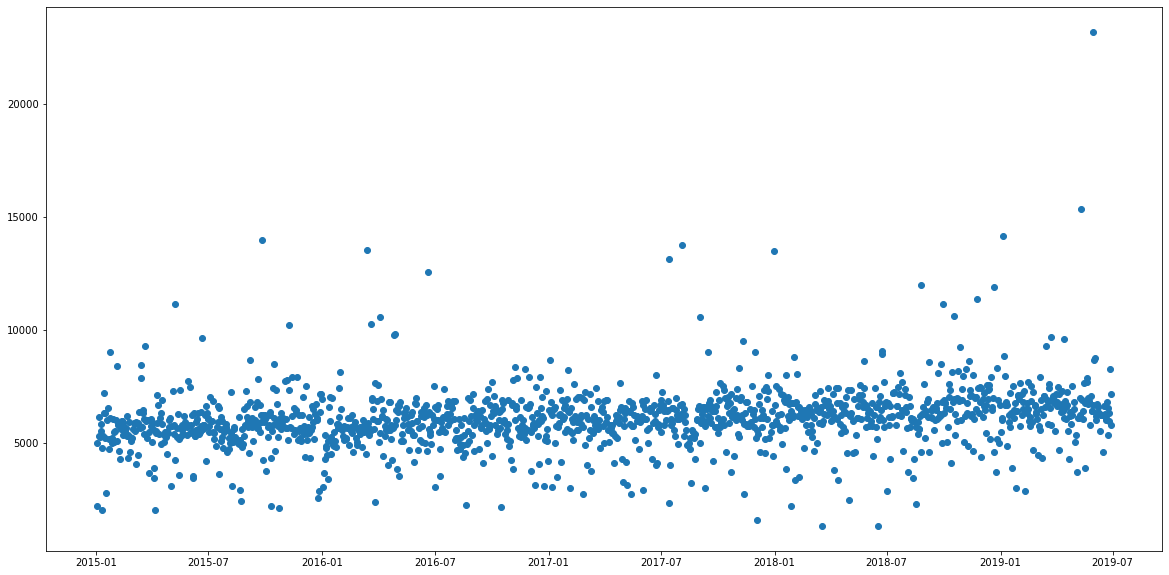

In [24]:
real_estate_df_scatter = real_estate_df.select("*").groupBy('Sale_Date').agg({'Price_Sqm':'average'}).sort('Sale_Date', ascending=True)
#real_estate_df_scatter.show()

real_estate_df_scatter = real_estate_df_scatter.withColumn("Price_Sqmeters", F.round(real_estate_df_scatter["avg(Price_Sqm)"],0).cast('integer'))
#real_estate_df_scatter.show()

PSq_list = list(
    real_estate_df_scatter.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(PSq_list)

Date_list = list(
    real_estate_df_scatter.select('Sale_Date').toPandas()['Sale_Date']
)
#print(Date_list)

import pandas as pd
import matplotlib.pyplot as plt
data = real_estate_df_scatter[['Price_Sqmeters', 'Sale_Date']]
x = Date_list
y = PSq_list
plt.figure(1, figsize=(20,10))
plt.scatter(x, y)
plt.show()

### Study of Sqm per city (Bar Chart)

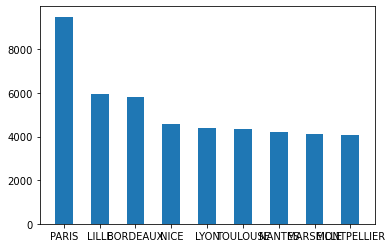

<Figure size 432x288 with 0 Axes>

In [25]:
#SQM_PER_CITY
#STEP1
real_estate_df = real_estate_df.withColumn("Price_Sqm",col('Price')/col('Living_Area'))
#real_estate_df.show(5)


#STEP2
real_estate_df = real_estate_df.withColumn("Price_Sqm", F.round(real_estate_df["Price_Sqm"],0).cast('integer'))
#real_estate_df.show()


#STEP3
real_estate_df_city_hist = real_estate_df.select("*").groupBy('City').agg({'Price_Sqm':'average'}).sort('avg(Price_Sqm)', ascending=False)
#real_estate_df_city_hist.show()


#STEP4
real_estate_df_city_hist = real_estate_df_city_hist.withColumn("Price_Sqmeters", F.round(real_estate_df_city_hist["avg(Price_Sqm)"],0).cast('integer'))
#real_estate_df_city_hist.show()


#STEP5
list_city = list(
    real_estate_df_city_hist.select('City').toPandas()['City']
)
#print(list_city)

list_Price_Sqmeters = list(
    real_estate_df_city_hist.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Price_Sqmeters)


#STEP 6
from matplotlib import pyplot 
import matplotlib.pyplot as plt
length = real_estate_df_city_hist.collect()
indexes = list(range(len(length)))
 
values = list_Price_Sqmeters
labels = list_city

#Plotting
bar_width = 0

pyplot.bar(indexes, values,width = 0.5)

#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels)
plt.xticks(fontsize=10)

import matplotlib.pyplot as plt
fig= pyplot.figure()

pyplot.show()

### Study of the evolution of Sqm per city (2 Multiple Line Charts) #1

<ipython-input-26-3b8828b5a855>:111: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, color='grey', linewidth=4)
<ipython-input-26-3b8828b5a855>:112: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y2', data=df, color='blue', linewidth=8)
<ipython-input-26-3b8828b5a855>:113: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data.  If it w

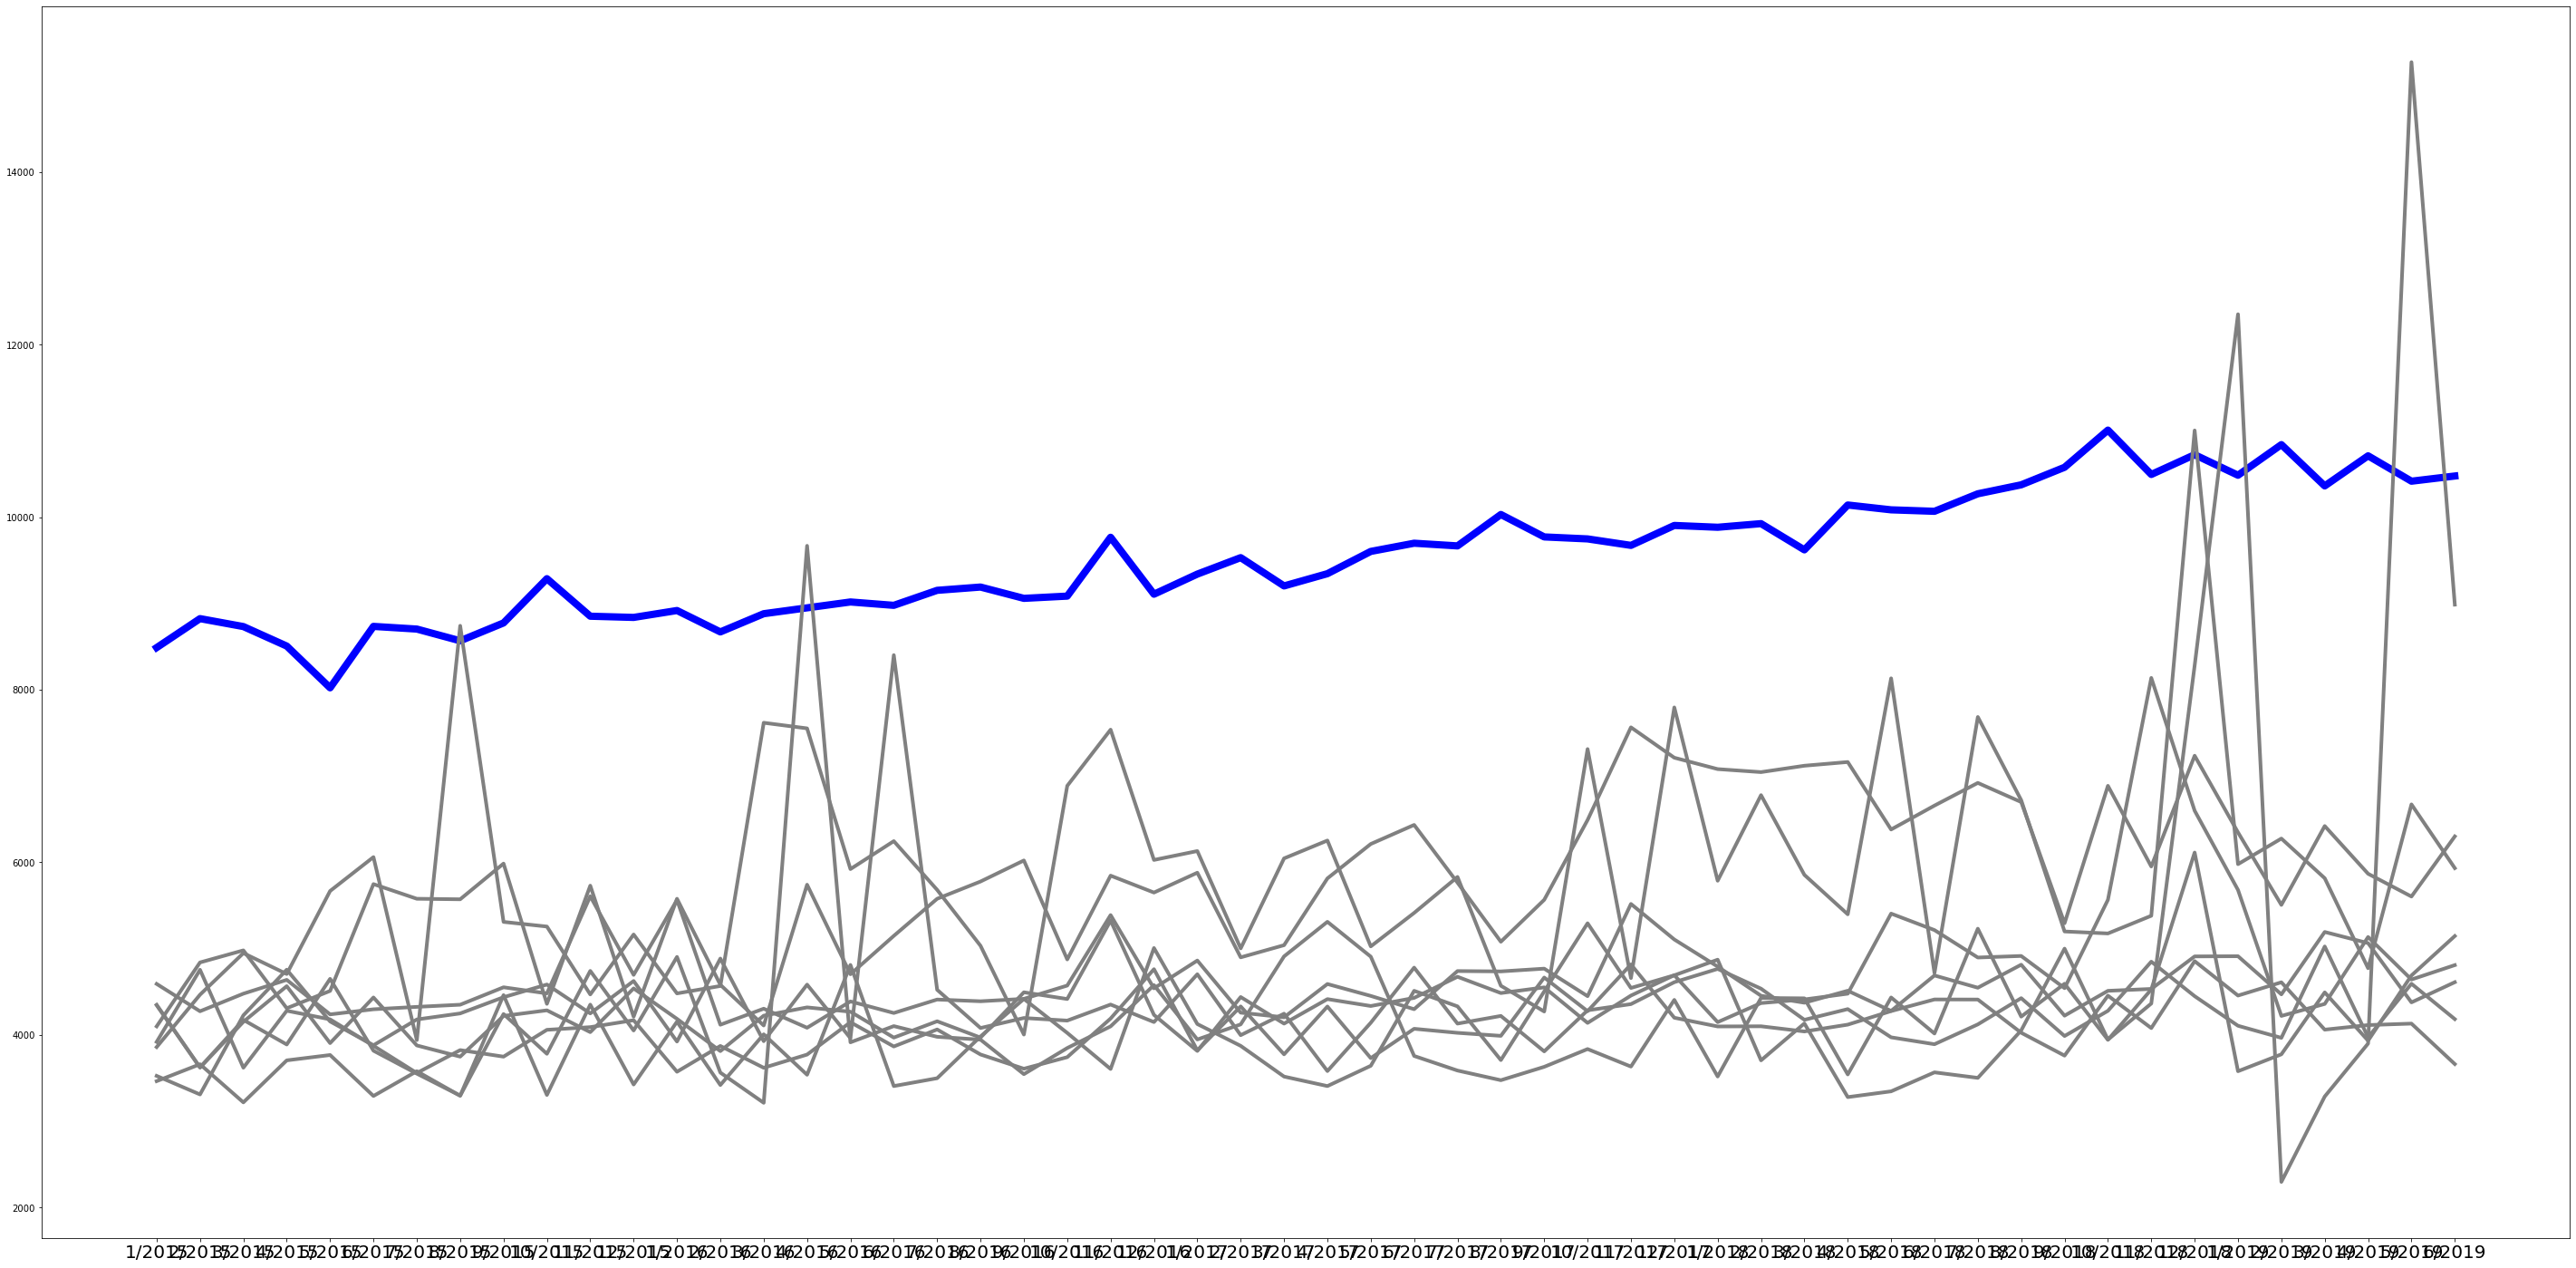

In [26]:
#MULTI(1)
real_estate_df_city_line = real_estate_df.select("*").groupBy('Years','Months','City').agg({'Price_Sqm':'average'}).sort('City','Years','Months', ascending=True)
#real_estate_df_city_line.show()

real_estate_df_city_line = real_estate_df_city_line.withColumn("Price_Sqmeters", F.round(real_estate_df_city_line["avg(Price_Sqm)"],0).cast('integer'))
#real_estate_df_sqm_years.show()

#MULTI(2)
real_estate_df_city_line = real_estate_df_city_line.withColumn('Month_of_Year', 
                    F.concat(F.col('Months'),F.lit('/'), F.col('Years')))
#real_estate_df_city_line.show()


#MULTI(3)
real_estate_df_city_line_Bordeaux = real_estate_df_city_line.filter('City=="BORDEAUX"')
#real_estate_df_city_line_Bordeaux.show()

real_estate_df_city_line_Paris = real_estate_df_city_line.filter('City=="PARIS"')
#real_estate_df_city_line_Paris.show()

real_estate_df_city_line_Montpellier = real_estate_df_city_line.filter('City=="MONTPELLIER"')
#real_estate_df_city_line_Montpellier.show()

real_estate_df_city_line_Nantes = real_estate_df_city_line.filter('City=="NANTES"')
#real_estate_df_city_line_Nantes.show()

real_estate_df_city_line_Lille = real_estate_df_city_line.filter('City=="LILLE"')
#real_estate_df_city_line_Lille.show()

real_estate_df_city_line_Toulouse = real_estate_df_city_line.filter('City=="TOULOUSE"')
#real_estate_df_city_line_Toulouse.show()

real_estate_df_city_line_Lyon = real_estate_df_city_line.filter('City=="LYON"')
#real_estate_df_city_line_Lyon.show()

real_estate_df_city_line_Marseille = real_estate_df_city_line.filter('City=="MARSEILLE"')
#real_estate_df_city_line_Marseille.show()

real_estate_df_city_line_Nice = real_estate_df_city_line.filter('City=="NICE"')
#real_estate_df_city_line_Nice.show()


#MULTI(4)
#Year_Data
list_month_of_year = list(
    real_estate_df_city_line_Nice.select('Month_Of_Year').toPandas()['Month_Of_Year']
)
#print(list_month_of_year)

#Cities_Data
list_Sqm_Bordeaux = list(
    real_estate_df_city_line_Bordeaux.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Bordeaux)

list_Sqm_Paris = list(
    real_estate_df_city_line_Paris.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Paris)

list_Sqm_Montpellier = list(
    real_estate_df_city_line_Montpellier.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Montpellier)

list_Sqm_Nantes = list(
    real_estate_df_city_line_Nantes.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Nantes)

list_Sqm_Lille = list(
    real_estate_df_city_line_Lille.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Lille)

list_Sqm_Toulouse = list(
    real_estate_df_city_line_Toulouse.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Toulouse)

list_Sqm_Lyon = list(
    real_estate_df_city_line_Lyon.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Lyon)

list_Sqm_Marseille = list(
    real_estate_df_city_line_Marseille.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Marseille)

list_Sqm_Nice = list(
    real_estate_df_city_line_Nice.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(list_Sqm_Nice)


#MULTI(5)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df=pd.DataFrame({'x': list_month_of_year, 'y1': list_Sqm_Bordeaux, 'y2': list_Sqm_Paris, 'y3': list_Sqm_Montpellier
                                        , 'y4': list_Sqm_Nantes, 'y5': list_Sqm_Lille, 'y6': list_Sqm_Toulouse
                                        , 'y7': list_Sqm_Lyon, 'y8': list_Sqm_Marseille, 'y9': list_Sqm_Nice})
                
plt.figure(1, figsize=(50,25))
plt.xticks(fontsize=20)

# multiple line plot
plt.plot( 'x', 'y1', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y2', data=df, color='blue', linewidth=8)
plt.plot( 'x', 'y3', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y4', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y5', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y6', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y7', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y8', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y9', data=df, color='grey', linewidth=4)
#plt.legend(['Month of Sale Year'],['Nice'],['Marseille'])


### Study of the evolution of Sqm per city (2 Multiple Line Charts) #2

<ipython-input-27-5a38a82073fd>:14: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, color='green', linewidth=7)
<ipython-input-27-5a38a82073fd>:16: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y3', data=df, color='red', linewidth=7)
<ipython-input-27-5a38a82073fd>:17: RuntimeWarning: Second argument 'y4' is ambiguous: could be a format string but is in 'data'; using as data.  If it was 

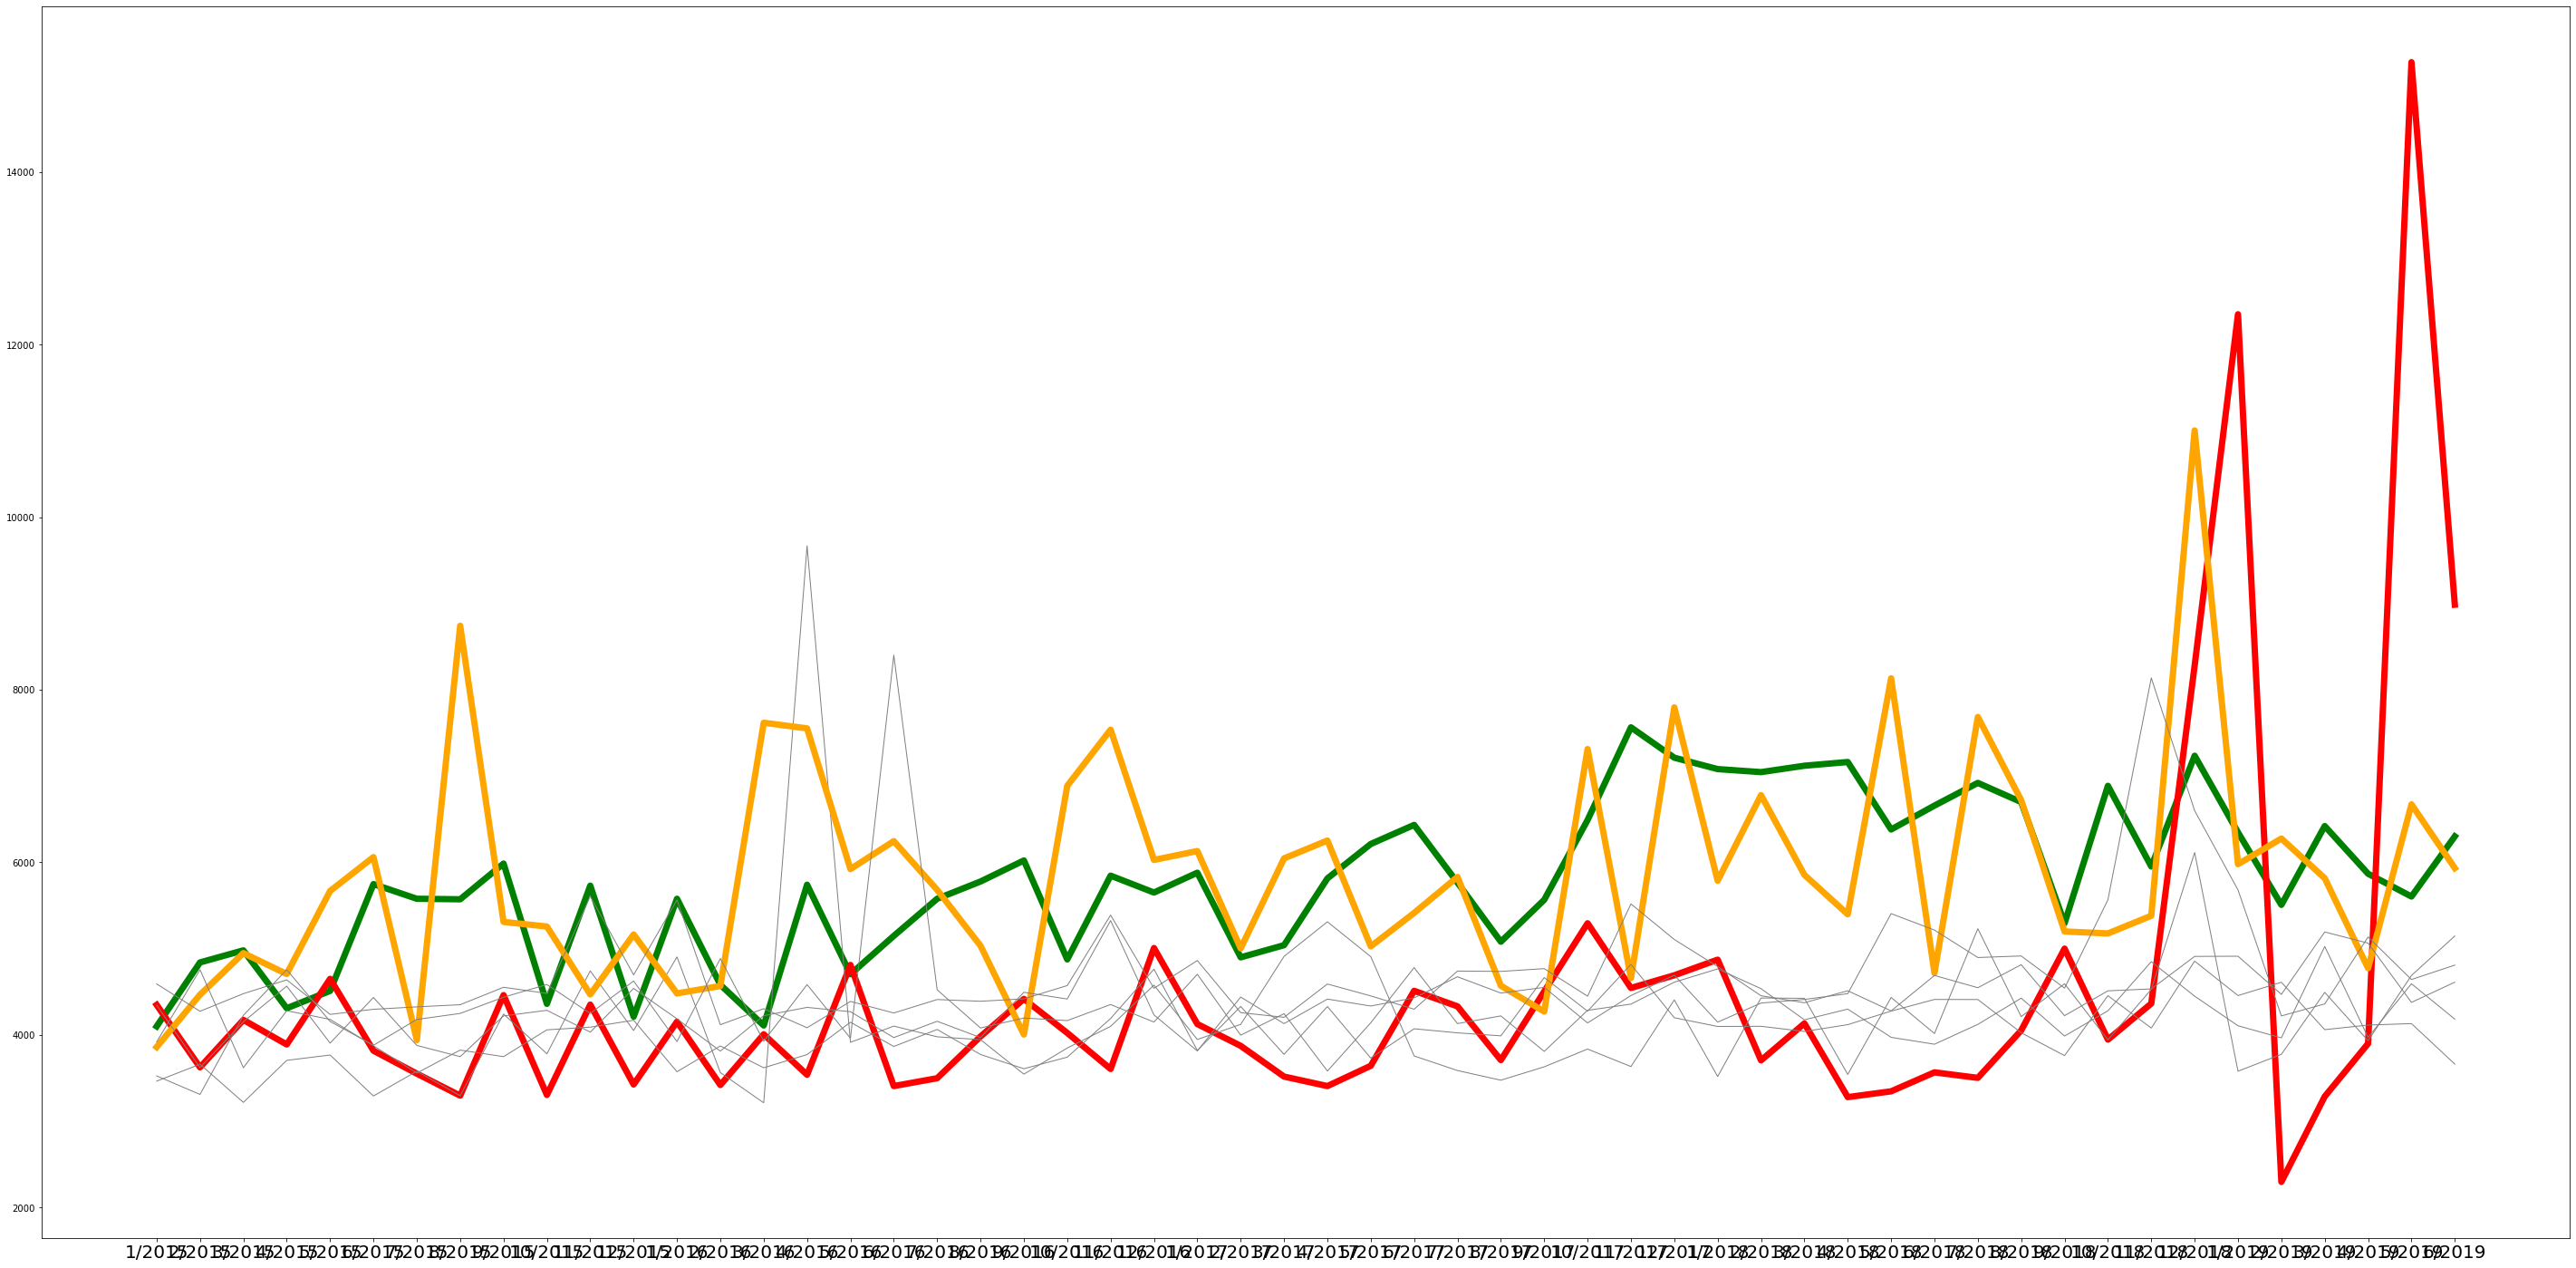

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df=pd.DataFrame({'x': list_month_of_year, 'y1': list_Sqm_Bordeaux, 'y2': list_Sqm_Paris, 'y3': list_Sqm_Montpellier
                                        , 'y4': list_Sqm_Nantes, 'y5': list_Sqm_Lille, 'y6': list_Sqm_Toulouse
                                        , 'y7': list_Sqm_Lyon, 'y8': list_Sqm_Marseille, 'y9': list_Sqm_Nice})
                
plt.figure(1, figsize=(50,25))
plt.xticks(fontsize=20)

# multiple line plot
plt.plot( 'x', 'y1', data=df, color='green', linewidth=7)
#plt.plot( 'x', 'y2', data=df, color='blue', linewidth=4)
plt.plot( 'x', 'y3', data=df, color='red', linewidth=7)
plt.plot( 'x', 'y4', data=df, color='grey', linewidth=1)
plt.plot( 'x', 'y5', data=df, color='orange', linewidth=7)
plt.plot( 'x', 'y6', data=df, color='grey', linewidth=1)
plt.plot( 'x', 'y7', data=df, color='grey', linewidth=1)
plt.plot( 'x', 'y8', data=df, color='grey', linewidth=1)
plt.plot( 'x', 'y9', data=df, color='grey', linewidth=1)
#plt.legend(['Month of Sale Year'],['Nice'],['Marseille'])


##    PART 3 - B2C SALES ANALYSIS - TURNOVER AND NUMBER OF SALES (SPLIT BY CITY WITH AN SCALABLE VIEW)


###  3.1 - Spreading of the Turnover and Number of Sales per City (NoS) per City (2 Pie Charts)

In [28]:
real_estate_df = B2C_df

<ipython-input-29-a632b6ec6d2b>:31: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(sizes, explode=explode, labels=labels,


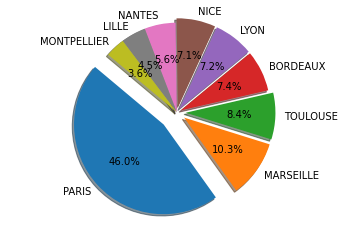

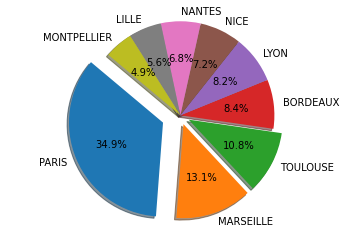

In [29]:
#TURNOVER_DISTRIBUTION_PER_CITY
real_estate_df_city_turnover = real_estate_df.select("*").groupBy('City').agg({'Price':'sum'}).sort('sum(Price)', ascending=False)
#real_estate_df_city_turnover.show()

real_estate_df_city_nbsales = real_estate_df.select("*").groupBy('City').agg({'Price':'count'}).sort('count(Price)', ascending=False)
#real_estate_df_city_nbsales.show()

from pyspark.sql.window import Window
real_estate_df_city_turnover = real_estate_df_city_turnover.withColumn('Turnover_percent', F.col('sum(Price)')/F.sum('sum(Price)').over(Window.partitionBy()))
#real_estate_df_city_turnover.show()

real_estate_df_city_nbsales = real_estate_df_city_nbsales.withColumn('Nb_of_Sales_percent', F.col('count(Price)')/F.sum('count(Price)').over(Window.partitionBy()))
#real_estate_df_city_nbsales.show()

list_Turnover_city = list(
    real_estate_df_city_turnover.select('Turnover_percent').toPandas()['Turnover_percent']
)
#print(list_Turnover_city)

list_NbofSales_city = list(
    real_estate_df_city_nbsales.select('Nb_of_Sales_percent').toPandas()['Nb_of_Sales_percent']
)
#print(list_NbofSales_city)

#Turnover per City Plot
labels = 'PARIS', 'MARSEILLE', 'TOULOUSE', 'BORDEAUX','LYON', 'NICE', 'NANTES', 'LILLE','MONTPELLIER'
sizes = list_Turnover_city
explode = (0.2,0.1,0.1,0.05,0.05,0.05,0,0,0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#Nb of Sales per City Plot
labels = 'PARIS', 'MARSEILLE', 'TOULOUSE', 'BORDEAUX','LYON', 'NICE', 'NANTES', 'LILLE','MONTPELLIER'
sizes = list_NbofSales_city
explode = (0.2,0.1,0.1,0.0,0.0,0.0,0,0,0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

### 3.2 - Study of the evolution of Turnover and NoS per City (2 Multiple Line Charts) #1

<ipython-input-30-b64ec499bce6>:108: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, color='grey', linewidth=4)
<ipython-input-30-b64ec499bce6>:109: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y2', data=df, color='blue', linewidth=4)
<ipython-input-30-b64ec499bce6>:110: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data.  If it w

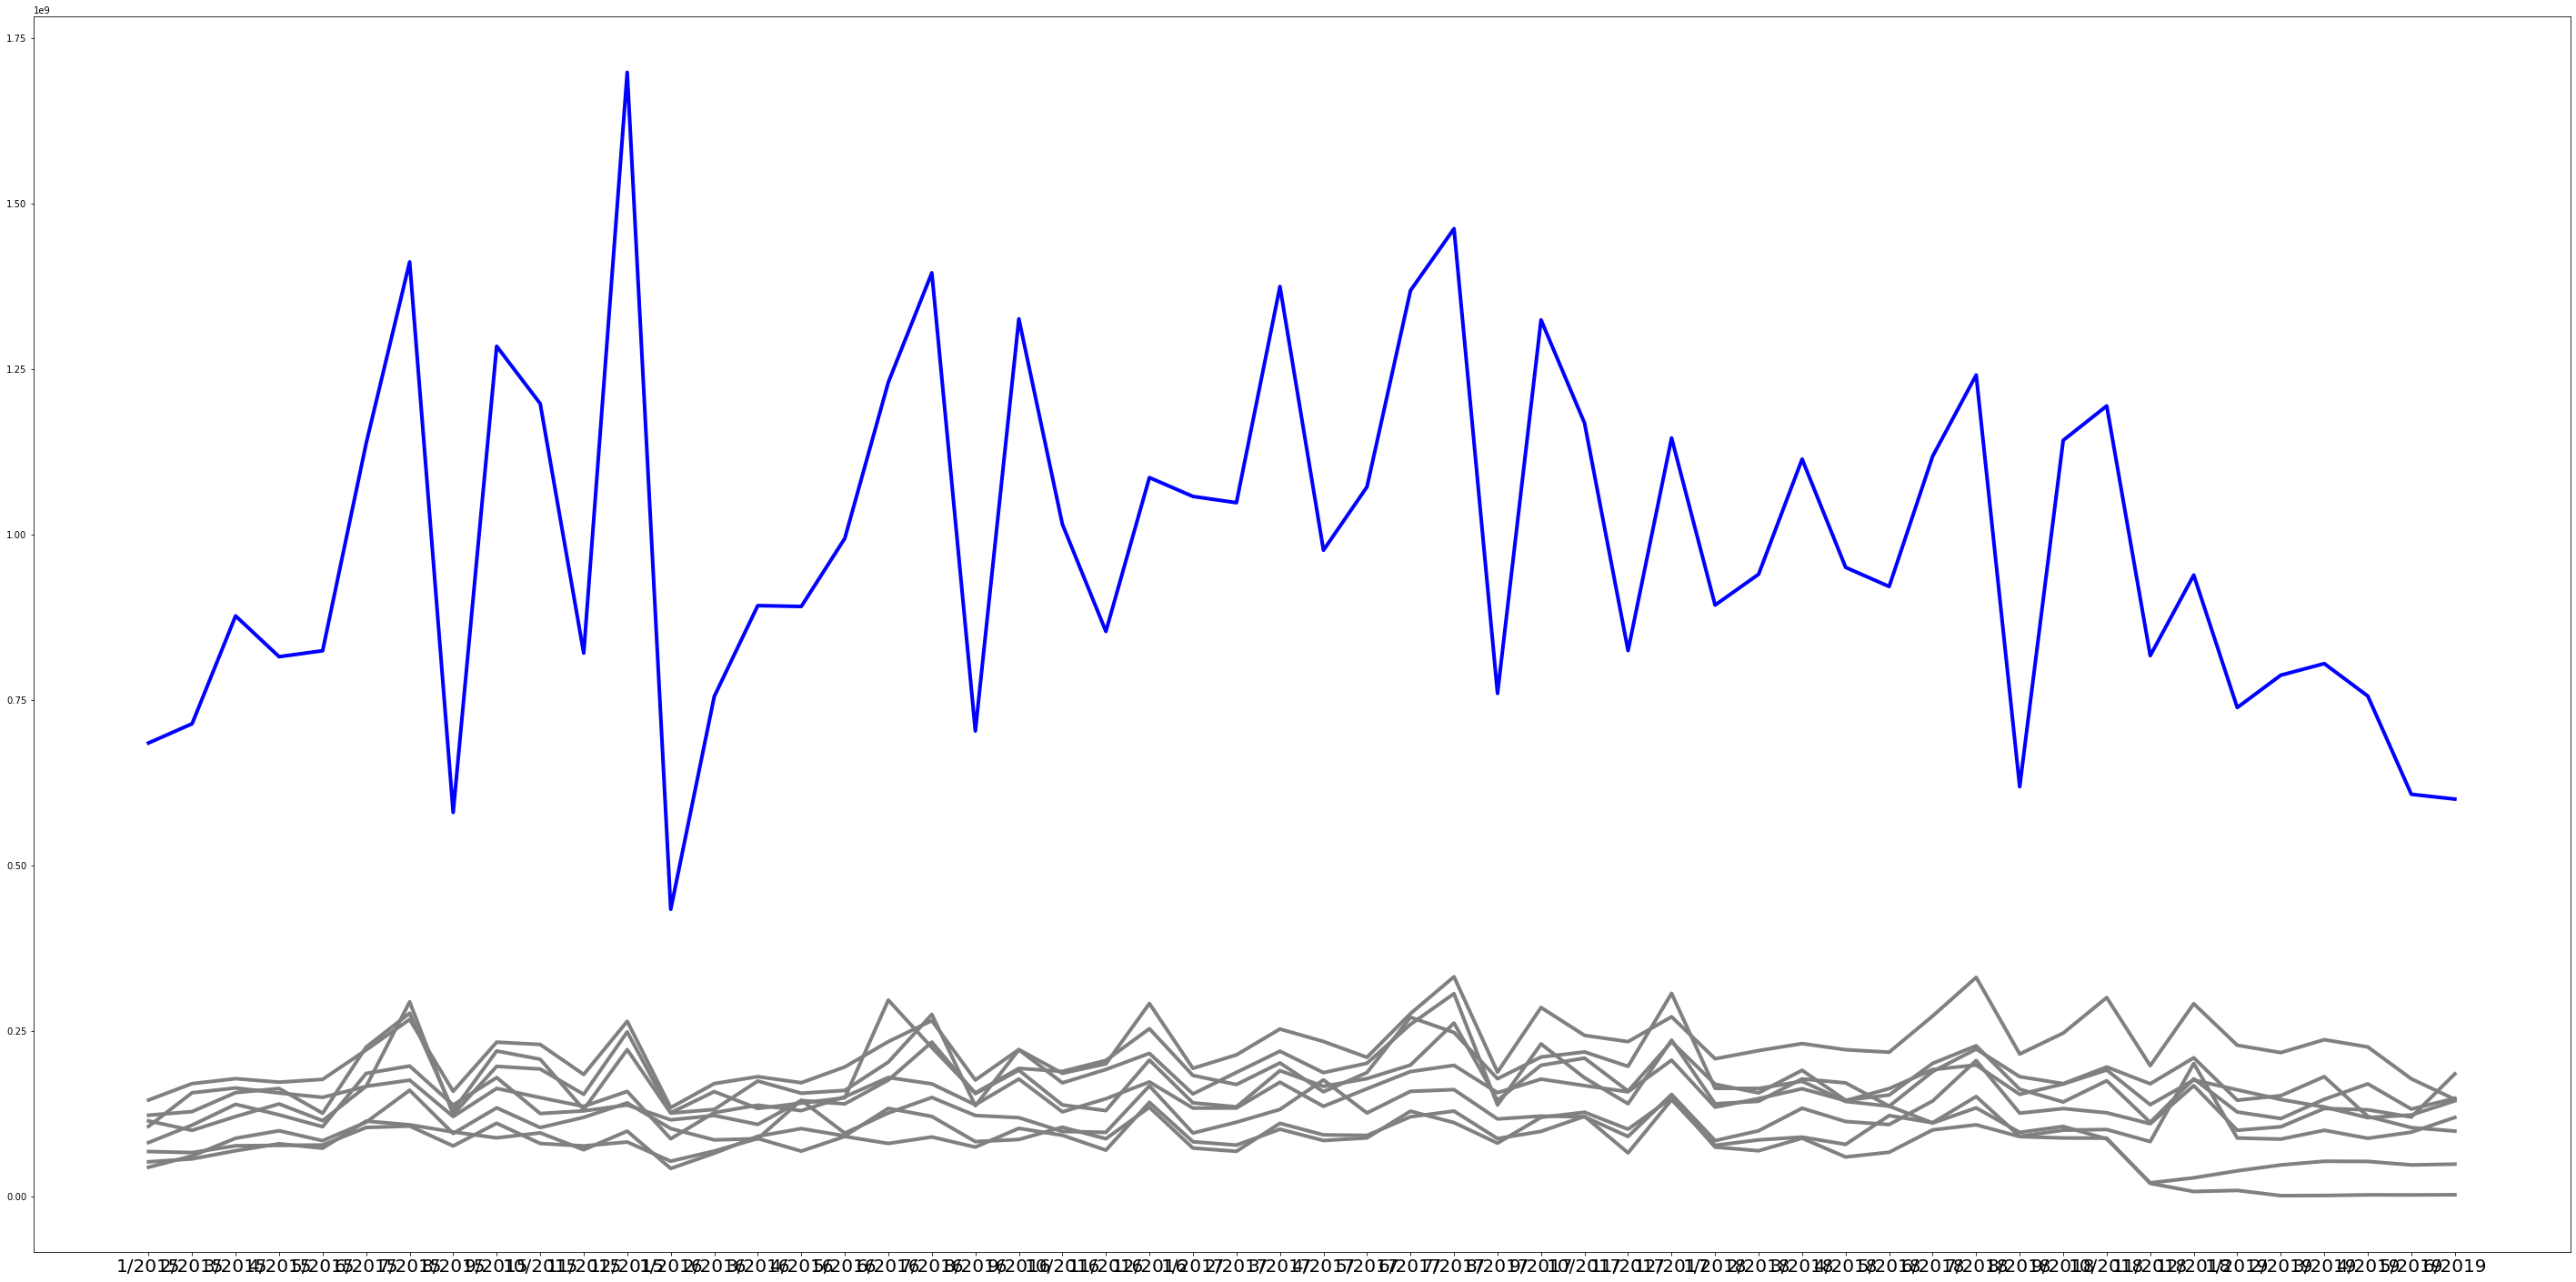

In [30]:
#MULTI(1)
real_estate_df_city_line = real_estate_df.select("*").groupBy('Years','Months','City').agg({'Price':'sum'}).sort('City','Years','Months', ascending=True)
#real_estate_df_city_line.show()

#MULTI(2)
real_estate_df_city_line = real_estate_df_city_line.withColumn('Month_of_Year', 
                    F.concat(F.col('Months'),F.lit('/'), F.col('Years')))
#real_estate_df_city_line.show()


#MULTI(3)
real_estate_df_city_line_Bordeaux = real_estate_df_city_line.filter('City=="BORDEAUX"')
#real_estate_df_city_line_Bordeaux.show()

real_estate_df_city_line_Paris = real_estate_df_city_line.filter('City=="PARIS"')
#real_estate_df_city_line_Paris.show()

real_estate_df_city_line_Montpellier = real_estate_df_city_line.filter('City=="MONTPELLIER"')
#real_estate_df_city_line_Montpellier.show()

real_estate_df_city_line_Nantes = real_estate_df_city_line.filter('City=="NANTES"')
#real_estate_df_city_line_Nantes.show()

real_estate_df_city_line_Lille = real_estate_df_city_line.filter('City=="LILLE"')
#real_estate_df_city_line_Lille.show()

real_estate_df_city_line_Toulouse = real_estate_df_city_line.filter('City=="TOULOUSE"')
#real_estate_df_city_line_Toulouse.show()

real_estate_df_city_line_Lyon = real_estate_df_city_line.filter('City=="LYON"')
#real_estate_df_city_line_Lyon.show()

real_estate_df_city_line_Marseille = real_estate_df_city_line.filter('City=="MARSEILLE"')
#real_estate_df_city_line_Marseille.show()

real_estate_df_city_line_Nice = real_estate_df_city_line.filter('City=="NICE"')
#real_estate_df_city_line_Nice.show()


#MULTI(4)
#Year_Data
list_month_of_year = list(
    real_estate_df_city_line_Nice.select('Month_Of_Year').toPandas()['Month_Of_Year']
)
#print(list_month_of_year)

#Cities_Data
list_Price_Bordeaux = list(
    real_estate_df_city_line_Bordeaux.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Bordeaux)

list_Price_Paris = list(
    real_estate_df_city_line_Paris.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Paris)

list_Price_Montpellier = list(
    real_estate_df_city_line_Montpellier.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Montpellier)

list_Price_Nantes = list(
    real_estate_df_city_line_Nantes.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Nantes)

list_Price_Lille = list(
    real_estate_df_city_line_Lille.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Lille)

list_Price_Toulouse = list(
    real_estate_df_city_line_Toulouse.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Toulouse)

list_Price_Lyon = list(
    real_estate_df_city_line_Lyon.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Lyon)

list_Price_Marseille = list(
    real_estate_df_city_line_Marseille.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Marseille)

list_Price_Nice = list(
    real_estate_df_city_line_Nice.select('sum(Price)').toPandas()['sum(Price)']
)
#print(list_Price_Nice)


#MULTI(5)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df=pd.DataFrame({'x': list_month_of_year, 'y1': list_Price_Bordeaux, 'y2': list_Price_Paris, 'y3': list_Price_Montpellier
                                        , 'y4': list_Price_Nantes, 'y5': list_Price_Lille, 'y6': list_Price_Toulouse
                                        , 'y7': list_Price_Lyon, 'y8': list_Price_Marseille, 'y9': list_Price_Nice})
                
plt.figure(1, figsize=(50,25))
plt.xticks(fontsize=20)

# multiple line plot
plt.plot( 'x', 'y1', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y2', data=df, color='blue', linewidth=4)
plt.plot( 'x', 'y3', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y4', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y5', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y6', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y7', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y8', data=df, color='grey', linewidth=4)
plt.plot( 'x', 'y9', data=df, color='grey', linewidth=4)
#plt.legend(['Month of Sale Year'],['Nice'],['Marseille'])


### 3.2 - Study of the evolution of Turnover and NoS per City (2 Multiple Line Charts) #2

<ipython-input-31-499a9256b2d9>:14: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, color='grey', linewidth=1)
<ipython-input-31-499a9256b2d9>:16: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y3', data=df, color='red', linewidth=3)
<ipython-input-31-499a9256b2d9>:17: RuntimeWarning: Second argument 'y4' is ambiguous: could be a format string but is in 'data'; using as data.  If it was i

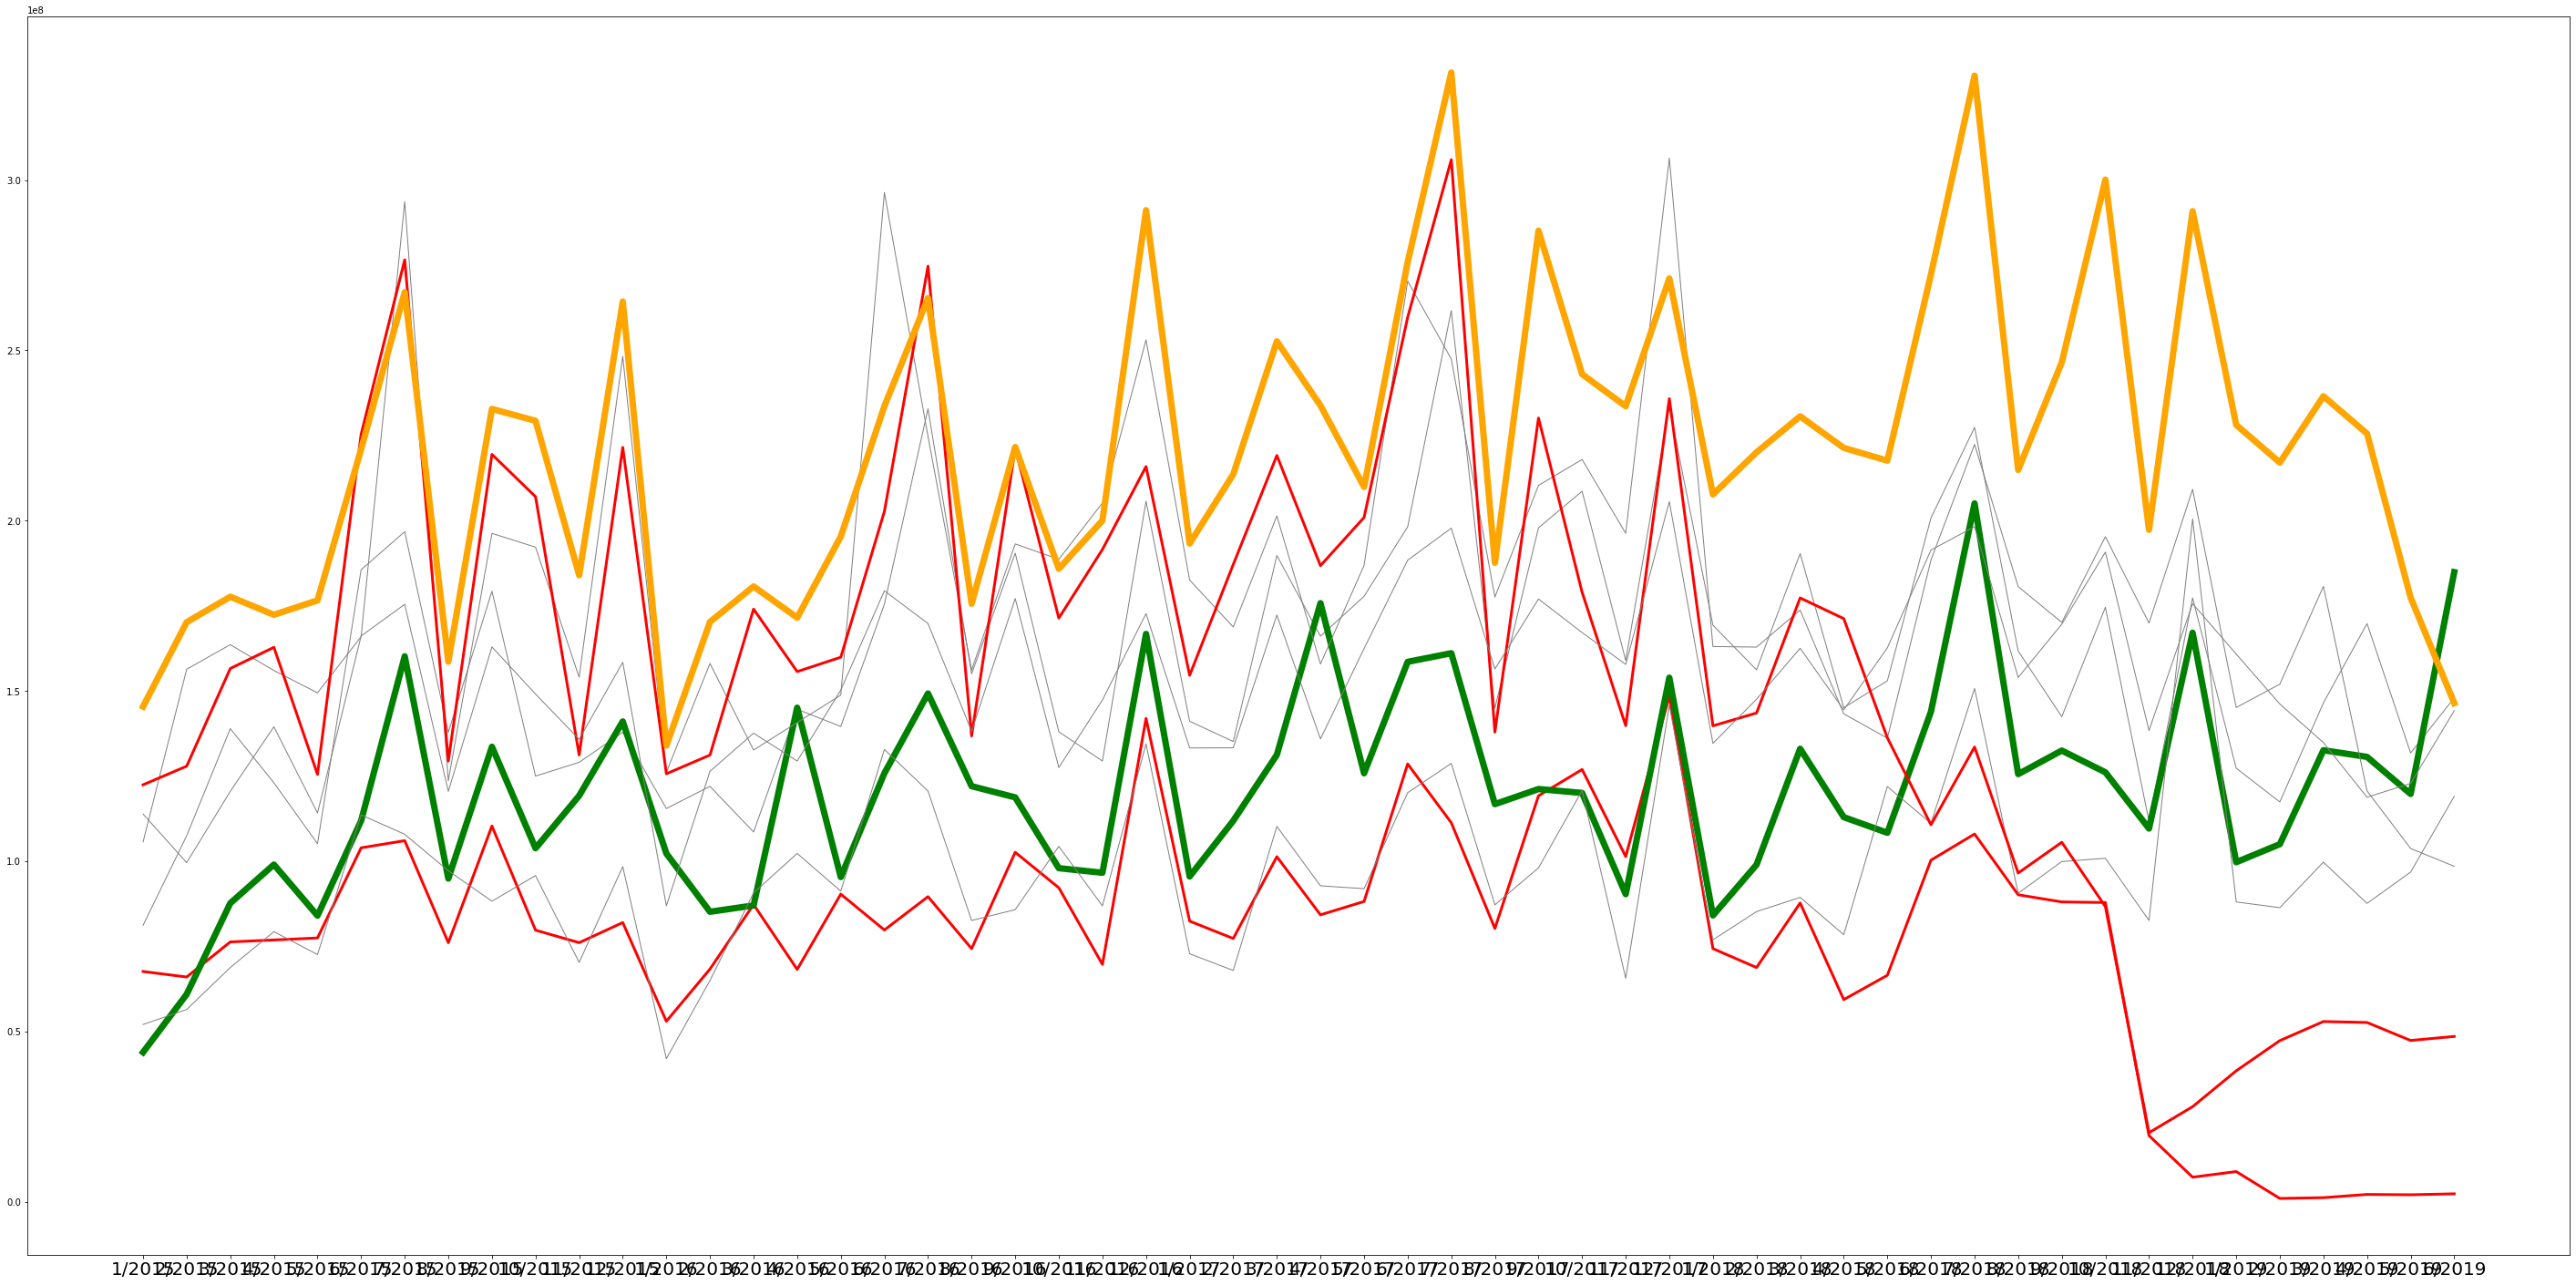

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df=pd.DataFrame({'x': list_month_of_year, 'y1': list_Price_Bordeaux, 'y2': list_Price_Paris, 'y3': list_Price_Montpellier
                                        , 'y4': list_Price_Nantes, 'y5': list_Price_Lille, 'y6': list_Price_Toulouse
                                        , 'y7': list_Price_Lyon, 'y8': list_Price_Marseille, 'y9': list_Price_Nice})
                
plt.figure(1, figsize=(50,25))
plt.xticks(fontsize=20)

# multiple line plot
plt.plot( 'x', 'y1', data=df, color='grey', linewidth=1)
#plt.plot( 'x', 'y2', data=df, color='blue', linewidth=4)
plt.plot( 'x', 'y3', data=df, color='red', linewidth=3)
plt.plot( 'x', 'y4', data=df, color='green', linewidth=7)
plt.plot( 'x', 'y5', data=df, color='grey', linewidth=1)
plt.plot( 'x', 'y6', data=df, color='grey', linewidth=1)
plt.plot( 'x', 'y7', data=df, color='red', linewidth=3)
plt.plot( 'x', 'y8', data=df, color='orange', linewidth=7)
plt.plot( 'x', 'y9', data=df, color='grey', linewidth=1)
#plt.legend(['Month of Sale Year'],['Nice'],['Marseille'])


##    B2B ANALYSIS - MARKET ANALYSIS AND OPPORTUNIES FOR THE COMPANY


### 4.1 - B2B extrem values cleaning

In [32]:
#(REPOST) B2B_SUBSET_CREATING

#B2B_OUTLIERS_INTO_THE_DATASET
B2B_df_p = B2B_df.agg(
                                    F.expr('percentile(Price, array(0.005))')[0].alias('%0,5'),
                                    F.expr('percentile(Price, array(0.01))')[0].alias('%1'),
                                    F.expr('percentile(Price, array(0.01))')[0].alias('%5'),
                                    F.expr('percentile(Price, array(0.10))')[0].alias('%10'),
                                    F.expr('percentile(Price, array(0.20))')[0].alias('%20'),
                                    F.expr('percentile(Price, array(0.30))')[0].alias('%30'),
                                    F.expr('percentile(Price, array(0.40))')[0].alias('%40'),
                                    F.expr('percentile(Price, array(0.50))')[0].alias('%50'),
                                    F.expr('percentile(Price, array(0.60))')[0].alias('%60'),
                                    F.expr('percentile(Price, array(0.70))')[0].alias('%70'),
                                    F.expr('percentile(Price, array(0.80))')[0].alias('%80'),
                                    F.expr('percentile(Price, array(0.90))')[0].alias('%90'),
                                    F.expr('percentile(Price, array(0.95))')[0].alias('%95'),
                                    F.expr('percentile(Price, array(0.99))')[0].alias('%99'))

B2B_df_p.show()

#DELETE_OUTLIERS
B2B_df = B2B_df.filter('Price<9250000.0')
#B2B_df.show()
B2B_df = B2B_df.filter('Price>80000.0')
#B2B_df.show()

+----+---+---+-------+--------+--------+--------+--------+--------+---------+---------+---------+--------+------+
|%0,5| %1| %5|    %10|     %20|     %30|     %40|     %50|     %60|      %70|      %80|      %90|     %95|   %99|
+----+---+---+-------+--------+--------+--------+--------+--------+---------+---------+---------+--------+------+
| 1.0|1.0|1.0|80000.0|138000.0|210000.0|307000.0|460000.0|750000.0|1370000.0|3000000.0|9250000.0|2.1705E7|6.39E7|
+----+---+---+-------+--------+--------+--------+--------+--------+---------+---------+---------+--------+------+



### 4.2 - Spreading of Turnover and the NoS per type of sale (2 Pie Charts)

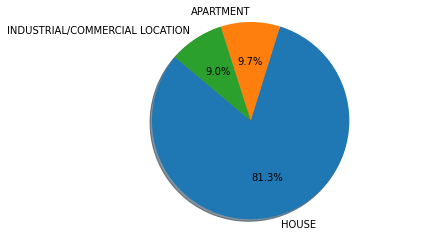

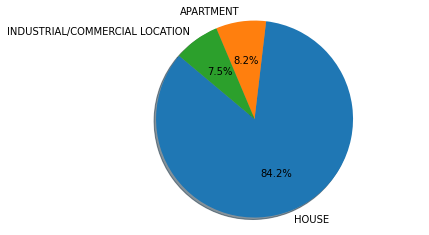

In [33]:
# B2B_NB_SALES_COUNTING
B2B_df_a = B2B_df.select("*").agg({'Sale_Type':'count'})
#B2B_df_a.show()

#B2C_NB_SALES_COUNTING
B2C_df_a = B2C_df.select("*").agg({'Sale_Type':'count'})
#B2C_df_a.show()

Global_df = Global_df.filter('Local_Type=="HOUSE" or Local_Type=="APARTMENT" or Local_Type=="INDUSTRIAL/COMMERCIAL LOCATION"')

Global_df_p = Global_df.agg(
                                    F.expr('percentile(Price, array(0.005))')[0].alias('%0,5'),
                                    F.expr('percentile(Price, array(0.01))')[0].alias('%1'),
                                    F.expr('percentile(Price, array(0.01))')[0].alias('%5'),
                                    F.expr('percentile(Price, array(0.10))')[0].alias('%10'),
                                    F.expr('percentile(Price, array(0.20))')[0].alias('%20'),
                                    F.expr('percentile(Price, array(0.30))')[0].alias('%30'),
                                    F.expr('percentile(Price, array(0.40))')[0].alias('%40'),
                                    F.expr('percentile(Price, array(0.50))')[0].alias('%50'),
                                    F.expr('percentile(Price, array(0.60))')[0].alias('%60'),
                                    F.expr('percentile(Price, array(0.70))')[0].alias('%70'),
                                    F.expr('percentile(Price, array(0.80))')[0].alias('%80'),
                                    F.expr('percentile(Price, array(0.90))')[0].alias('%90'),
                                    F.expr('percentile(Price, array(0.95))')[0].alias('%95'),
                                    F.expr('percentile(Price, array(0.99))')[0].alias('%99'))

#Global_df_p.show()

#DELETE_OUTLIERS
Global_df = Global_df.filter('Price<1045803.0')
#Global_df.show()
Global_df = Global_df.filter('Price>85000.0')
#Global_df.show()

#GLOBAL_NB_SALES_COUNTING
Global_df_a = Global_df.select("*").agg({'Sale_Type':'count'})
#Global_df_a.show()


#TURNOVER_DISTRIBUTION_PER_CITY
Global_df_turnover = Global_df.select("*").groupBy('Local_Type').agg({'Price':'sum'}).sort('sum(Price)', ascending=False)
#Global_df_turnover.show()

Global_df_nbsales = Global_df.select("*").groupBy('Local_Type').agg({'Price':'count'}).sort('count(Price)', ascending=False)
#Global_df_nbsales.show()

from pyspark.sql.window import Window
Global_df_turnover = Global_df_turnover.withColumn('Turnover_percent', F.col('sum(Price)')/F.sum('sum(Price)').over(Window.partitionBy()))
#Global_df_turnover.show()

Global_df_nbsales = Global_df_nbsales.withColumn('Nb_of_Sales_percent', F.col('count(Price)')/F.sum('count(Price)').over(Window.partitionBy()))
#Global_df_nbsales.show()


list_Turnover = list(
    Global_df_turnover.select('Turnover_percent').toPandas()['Turnover_percent']
)
#print(list_Turnover)

list_NbofSales = list(
    Global_df_nbsales.select('Nb_of_Sales_percent').toPandas()['Nb_of_Sales_percent']
)
#print(list_NbofSales)

#Turnover per City Plot
labels = 'HOUSE', 'APARTMENT', 'INDUSTRIAL/COMMERCIAL LOCATION'
sizes = list_Turnover
explode = (0,0,0)

# Plot
plt.pie(sizes, explode=explode, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#Nb of Sales per City Plot
labels = 'HOUSE', 'APARTMENT', 'INDUSTRIAL/COMMERCIAL LOCATION'
sizes = list_NbofSales
explode = (0,0,0)

# Plot
plt.pie(sizes, explode=explode, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

### 4.3 - Evolution of the Sqm B2B over the year (Line Chart)

In [34]:
 #B2B_df.show()

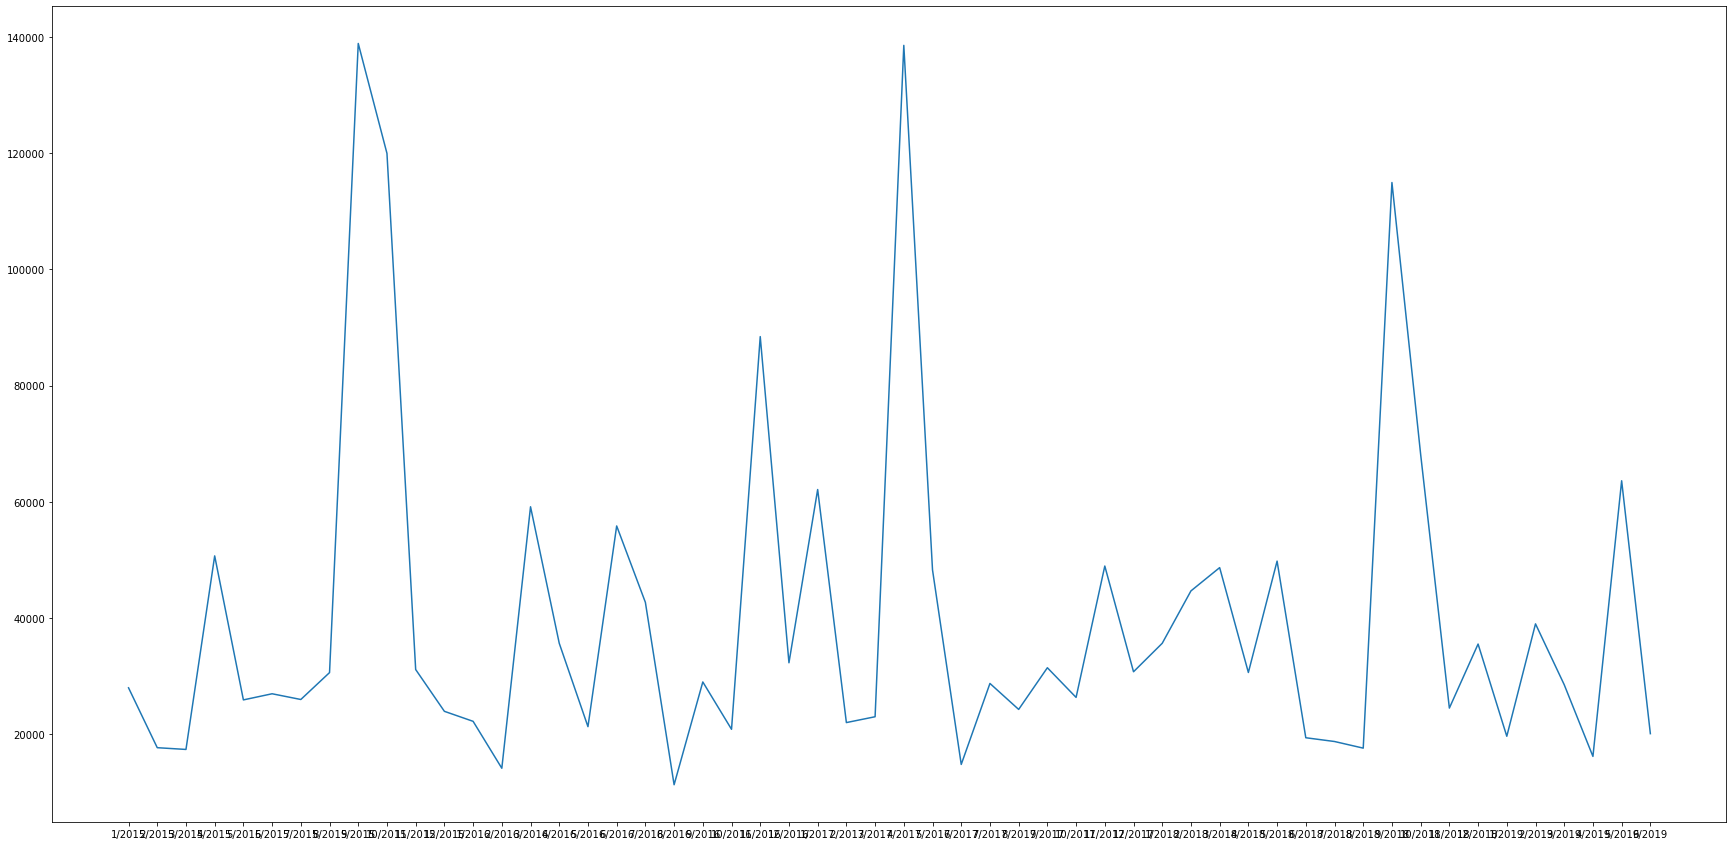

In [35]:
#STEP1
B2B_df = B2B_df.withColumn("Price_Sqm",col('Price')/col('Living_Area'))
#real_estate_df.show()

B2B_df =  B2B_df.withColumn("Price_Sqm", F.round(B2B_df["Price_Sqm"],0).cast('integer'))
#real_estate_df.show()

real_estate_df_sqm_years =  B2B_df.select("*").groupBy('Years','Months').agg({'Price_Sqm':'average'}).sort('Years','Months', ascending=True)
#real_estate_df_sqm_years.show()

#STEP2
real_estate_df_sqm_years = real_estate_df_sqm_years.withColumn("Price_Sqmeters", F.round(real_estate_df_sqm_years["avg(Price_Sqm)"],0).cast('integer'))
#real_estate_df_sqm_years.show()

#STEP4
real_estate_df_sqm_years = real_estate_df_sqm_years.withColumn('Month_of_Year', 
                    F.concat(F.col('Months'),F.lit('/'), F.col('Years')))
#real_estate_df_sqm_years.show()

#STEP4
PSq_list = list(
    real_estate_df_sqm_years.select('Price_Sqmeters').toPandas()['Price_Sqmeters']
)
#print(PSq_list)

Date_list = list(
    real_estate_df_sqm_years.select('Month_of_Year').toPandas()['Month_of_Year']
)
#print(Date_list)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

df=pd.DataFrame({'xvalues': Date_list, 'yvalues': PSq_list })
plt.figure(1, figsize=(30,15))

# plot
plt.plot('xvalues', 'yvalues', data=df)
x1 = plt
plt.show()